In [1]:
import h5py
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# Unistort the images using the camera properties
# 1. get the camera intrinsics
# 2. apply this every image in the "main" directory
# 3. save the undistorted image in the "proc_main" directory

# Obtain the file
filename = "camera_intrinsics.h5"
main_K, main_distortion = None, None

#Extracts the intrinsic K matrix and distortion vector from the h5 file
with h5py.File(filename, "r") as data:

    main_K = np.array(data["main"]["K"])
    main_distortion = np.array(data["main"]["distortion"])

#Reference: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

#Uses the intrinsics above to create an undistorted image and save it in a separate file under "proc_main"
images = os.listdir("main")
for file in images:
    img = cv.imread("main/" + file)
    if (img is not None):
        h,  w = img.shape[:2]
        newcameramtx, roi = cv.getOptimalNewCameraMatrix(main_K, main_distortion, (w,h), 1, (w,h))
        undistorted = cv.undistort(img, main_K, main_distortion, None, newcameramtx)

        # crop image
        x, y, w, h = roi
        undistorted = undistorted[y:y+h, x:x+w]

        new_name = "proc_main/proc_" + file
        cv.imwrite(new_name, undistorted)
    

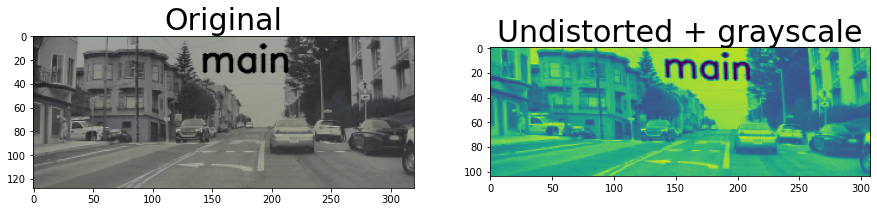

In [20]:
#plots the original and undistorted grayscale image
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

image_name = "0902.png"

# original, distorted, image
original = cv.imread("main/" + image_name)

# undistorted image
undist = cv.imread("proc_main/proc_" + image_name)
gray = cv.cvtColor(undist, cv.COLOR_BGR2GRAY)

ax[0].imshow(original)
ax[0].set_title('Original', fontsize=30)
ax[1].imshow(gray)
ax[1].set_title('Undistorted + grayscale', fontsize=30);

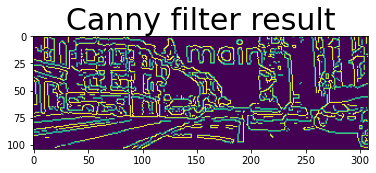

In [23]:
# (Unsuccessful) Canny Filter

# Blur the image to make borders more clear
blur_gray = cv.GaussianBlur(gray,(3, 3), 0)

# Apply Canny filter
img_can = cv.Canny(blur_gray, 45, 50) #threshold1 = 45, threshold2 = 50

plt.imshow(img_can)
plt.title('Canny filter result', fontsize=30);

# REMARK: this is actually succesful, but we have to select only the region of the road. Is this possible?

In [16]:
# Sobel Filter
#https://medium.com/swlh/computer-vision-advanced-lane-detection-through-thresholding-8a4dea839179

# Apply Sobel in the x and y direction
# (previously, we used a x = 1 + y = 1 direction together)
sobelx = cv.Sobel(gray, cv.CV_64F, 1, 0)
sobely = cv.Sobel(gray, cv.CV_64F, 0, 1)

# We have to take absolute value, otherwise negative gradients will be taken as 0 when converting to uint8
sobelx_abs = np.absolute(sobelx) 
sobely_abs = np.absolute(sobely)

conv_sobelx = np.uint8(255*sobelx_abs/np.max(sobelx_abs))
conv_sobely = np.uint8(255*sobely_abs/np.max(sobely_abs))

#create a binary mask of all zeroes, of the same size as the original image
binary = np.zeros_like(conv_sobelx)

# define sobel thresholds
x_min = 10
x_max = 100
y_min = 10
y_max = 100

#make binary pixel 1 if the sobelx and sobely pixel falls within the chosen threshold
binary[((conv_sobelx >= x_min) & (conv_sobelx <= x_max)) & ((conv_sobely >= y_min) & (conv_sobely <= y_max))] = 1

#make binary pixel 0 if it is outside of relevant image region
binary[0:60, :] = 0
binary[:, 150:] = 0

# REMARK: this region seems too much to the left. 
# It does even not always cature the whole relevant line (such as with image 0902)
# Moving this might solve a lot of problems?

Text(0.5, 1.0, 'Binary for Sobel filter, filtered for region of interest')

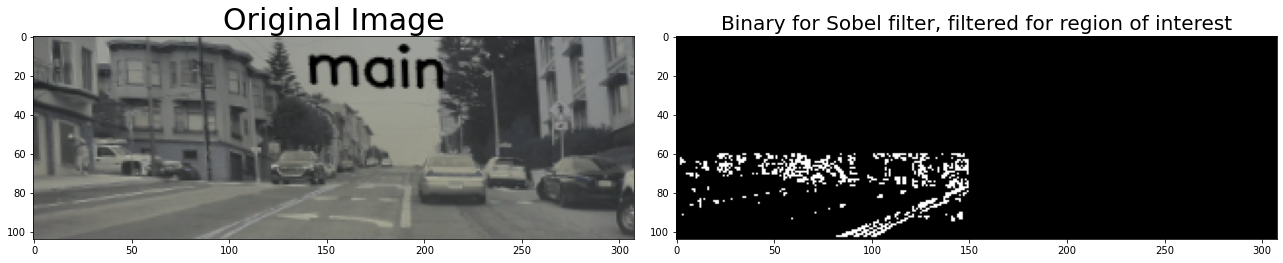

In [26]:
# Plot the result
f, ax = plt.subplots(1, 2, figsize=(18, 9))
f.tight_layout()

# The original image
ax[0].imshow(undist)
ax[0].set_title('Original Image', fontsize=30)

# The result of the sobel filter in x and y
ax[1].imshow(binary, cmap='gray')
ax[1].set_title('Binary for Sobel filter, filtered for region of interest', fontsize=20)

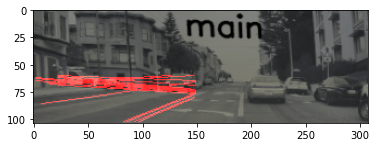

In [29]:
# (Unsuccesful) Hough Lines. Why? These lines are always linear, for one
# https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb

#create empty image
line_image = np.copy(undist) * 0

# Hough Lines, rho=1 and threshold=1
lines = cv.HoughLinesP(binary, 1, np.pi/180, 25, np.array([]), minLineLength=30, maxLineGap=50)

# Add hough lines to canvas (each line is made up of two endpoints, x1, y1  and x2, y2)
for line in lines:
    for x1, y1, x2, y2 in line:
        pts = np.array([[x1, y1 ], [x2, y2]], np.int32)
        cv.polylines(line_image, [pts], True, (255,0,0))

# Add the canvas w/ lines to the undistorted image and plot
lines_edges = cv.addWeighted(undist, 0.8, line_image, 1, 0)
plt.imshow(lines_edges)

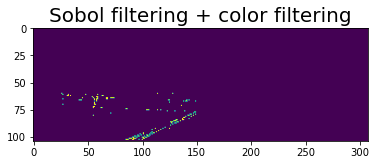

In [35]:
# Color Bounds method

# (Previously, we used RGB filtering)
# lower_bound = np.array([140, 140, 140]) #upper and lower RGB bounds
# upper_bound = np.array([148, 148, 148])

from scipy import optimize

# Define the hsv upper and lower bounds
hsv_upper = np.array([91, 15, 255])
hsv_lower = np.array([0, 0, 128])

# convert image to HSV format
hsv = cv.cvtColor(undist, cv.COLOR_BGR2HSV)

# find all pixels within this hsv range, in the relevant region of the image
in_bound = cv.inRange(hsv, hsv_lower, hsv_upper)

# Combine both the color filtering and sobol filtering
mask = in_bound & binary

plt.imshow(mask)
plt.title('Sobol filtering + color filtering', fontsize=20);

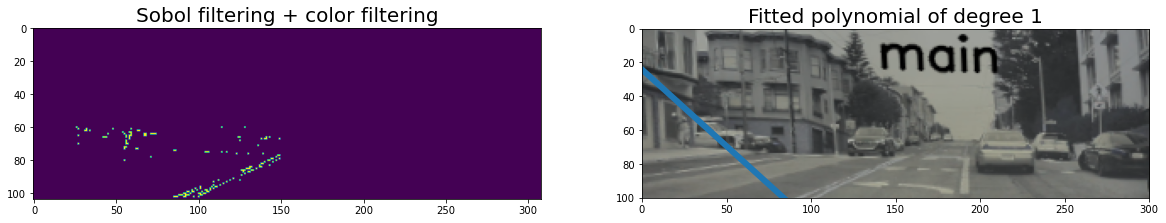

In [44]:
# Fitting a polynomial to the extracted points

# extract coordinates of each nonzero pixel
pts = np.array([(x, y) for y in range(len(mask[0])) for x in range(len(mask)) if mask[x, y] > 0])
ptsx = [pt[0] for pt in pts]
ptsy = [pt[1] for pt in pts]

# fit the points to a "degree" polynomial
degree = 1
fit = np.polyfit(ptsx, ptsy, degree)
#print(fit)

curve = np.poly1d(fit)
# What does this code do?
x_range = np.linspace(0, len(mask[0]))
y_range = curve(x_range)

# Plotting the color filtering and sobol filtering and fitted polynomial
fig, ax = plt.subplots(1, 2, figsize = (20, 15))

# Color filtering and sobol filtering
ax[0].imshow(mask)
ax[0].set_title('Sobol filtering + color filtering', fontsize=20)

# fitted polynomial
ax[1].plot(x_range, y_range, linewidth=6)
ax[1].set_xlim(0, 300)
ax[1].set_ylim(0, 100)
ax[1].imshow(undist)
ax[1].invert_yaxis()
ax[1].set_title('Fitted polynomial of degree ' + str(degree), fontsize=20);

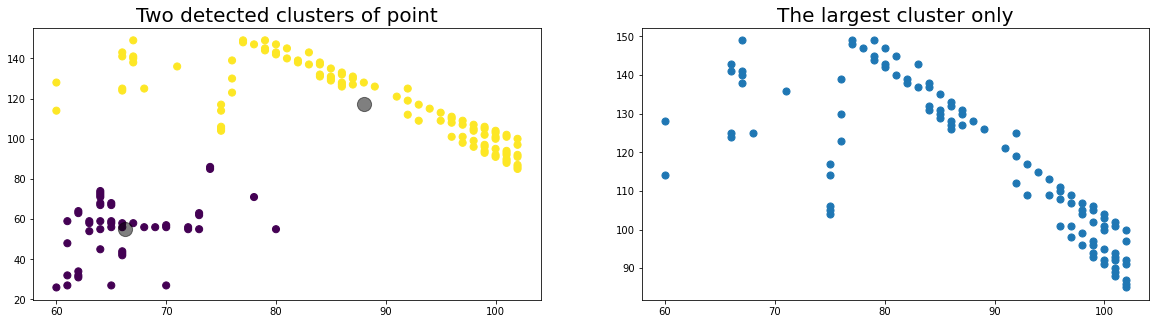

In [61]:
# Trying to extract only the useful points by clustering + filtering them

from sklearn.cluster import KMeans

# Setup an object for 2 clusters
kmeans = KMeans(n_clusters=2)
km_results = kmeans.fit(pts)
y_kmeans = kmeans.predict(pts)

# plot the two found clusters and the largest one
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

# plot the resulting 2 clusters and their centers
ax[0].scatter(pts[:, 0], pts[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
ax[0].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
ax[0].set_title('Two detected clusters of point', fontsize=20);

# find out what the index (either 0 or 1) of the largest cluster is 
# (i.e. the one with the most points)
# ASSUMPTION: the line we want to detect has the most points
largest_cluster_number = np.argmax(np.bincount(km_results.labels_))

# filter and retain only those points that belong to the largest cluster
filtered_pts = np.array([(x[0], x[1]) for ind, x in enumerate(pts) if km_results.labels_[ind] == largest_cluster_number])

# show this largest cluster
ax[1].scatter(filtered_pts[:, 0], filtered_pts[:, 1], s=50, cmap='viridis')
ax[1].set_title('The largest cluster only', fontsize=20);

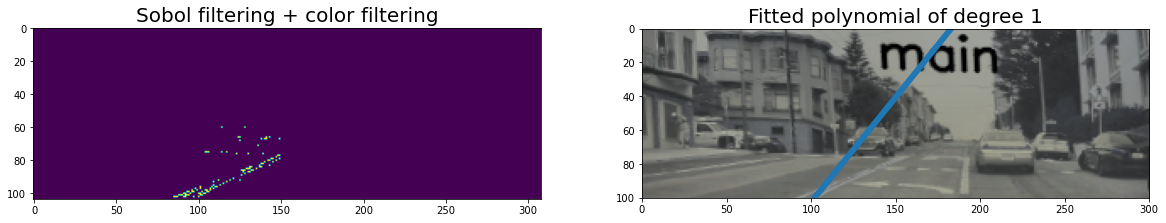

In [65]:
# Fitting a polynomial to the filtered, extracted points
filtered_ptsx = [pt[0] for pt in filtered_pts]
filtered_ptsy = [pt[1] for pt in filtered_pts]

# fit the points to a "degree" polynomial
degree = 1
fit = np.polyfit(filtered_ptsx, filtered_ptsy, degree)

curve = np.poly1d(fit)
# What does this code do?
x_range = np.linspace(0, len(mask[0]))
y_range = curve(x_range)

# Plotting pixels within the color bounds [0] and the fit overlaid on the undistorted image [1]
fig, ax = plt.subplots(1, 2, figsize = (20, 15))

# create a new, filtered mask
filtered_mask = np.copy(mask) * 0

for point in filtered_pts:
    filtered_mask[point[0]][point[1]] = 1

# Color filtering and sobol filtering
ax[0].imshow(filtered_mask)
ax[0].set_title('Sobol filtering + color filtering', fontsize=20)

# fitted polynomial
ax[1].plot(x_range, y_range, linewidth=6)
ax[1].set_xlim(0, 300)
ax[1].set_ylim(0, 100)
ax[1].imshow(undist)
ax[1].invert_yaxis()
ax[1].set_title('Fitted polynomial of degree ' + str(degree), fontsize=20);

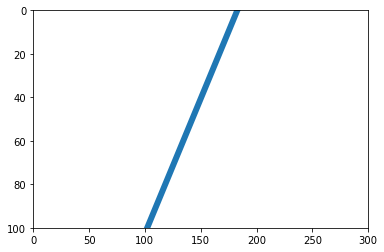

In [66]:
#plotting just the fit
plt.plot(x_range, y_range, linewidth=6)
plt.xlim(0, 300)
plt.ylim(0, 100)
plt.gca().invert_yaxis()


In [167]:
print(x_range)
print(y_range)

[  0.           6.28571429  12.57142857  18.85714286  25.14285714
  31.42857143  37.71428571  44.          50.28571429  56.57142857
  62.85714286  69.14285714  75.42857143  81.71428571  88.
  94.28571429 100.57142857 106.85714286 113.14285714 119.42857143
 125.71428571 132.         138.28571429 144.57142857 150.85714286
 157.14285714 163.42857143 169.71428571 176.         182.28571429
 188.57142857 194.85714286 201.14285714 207.42857143 213.71428571
 220.         226.28571429 232.57142857 238.85714286 245.14285714
 251.42857143 257.71428571 264.         270.28571429 276.57142857
 282.85714286 289.14285714 295.42857143 301.71428571 308.        ]
[ 295.2371935   282.89415983  270.55112617  258.2080925   245.86505883
  233.52202516  221.17899149  208.83595783  196.49292416  184.14989049
  171.80685682  159.46382316  147.12078949  134.77775582  122.43472215
  110.09168848   97.74865482   85.40562115   73.06258748   60.71955381
   48.37652015   36.03348648   23.69045281   11.34741914   -0.9

In [ ]:
# Load image
import cv2
image = undist
def nothing(x):
    pass
# Create a window
cv2.namedWindow('image')
cv2.namedWindow('pic')
# Create trackbars for color change
# Hue is from 0-179 for Opencv
cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# Set default value for Max HSV trackbars
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Initialize HSV min/max values
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

while(1):
    # Get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin', 'image')
    sMin = cv2.getTrackbarPos('SMin', 'image')
    vMin = cv2.getTrackbarPos('VMin', 'image')
    hMax = cv2.getTrackbarPos('HMax', 'image')
    sMax = cv2.getTrackbarPos('SMax', 'image')
    vMax = cv2.getTrackbarPos('VMax', 'image')

    # Set minimum and maximum HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Convert to HSV format and color threshold
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(image, image, mask=mask)

    # Print if there is a change in HSV value
    if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display result image
    cv2.imshow('pic', result)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 57, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 2), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 169), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 89), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 55), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 204, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 160, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 131, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 68, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 10, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 16, vMax = 255)
(hMi